In [1]:
from scipy.fftpack import dct, idct
from skimage import io
from skimage import color
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def PSNR(img, qimg):
    rows, cols = img.shape
    dif = 0.0
    for i in range(rows):
        for j in range(cols):
            dif = dif + (img[i][j] - qimg[i][j])**2
    MSE = dif / (rows * cols)
    PSNR = 10 * np.log10(255 * 255 / MSE)
    return PSNR


def QF(qt, qu):
    qt2 = np.zeros((8, 8))
    if qu <= 0:
        qu = 1
    if qu > 100:
        qu = 100

    if qu < 50:
        qu = 5000 / qu
    else:
        qu = 200 - qu * 2

    for i in range(0,8):
        for j in range(0,8):
            qt2[i][j] = qt[i][j] * qu / 100

    return qt2

In [3]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [4]:
def padding_img(img):
    rows, cols = img.shape

    if rows % 8 != 0:
        padding = np.zeros((1, cols))
        for i in range(8 - rows % 8):
            img = np.append(img, padding, 0)

    rows, cols = img.shape

    if cols % 8 != 0:
        padding = np.zeros((rows, 1))
        for i in range(8 - cols % 8):
            img = np.append(img, padding, 1)

    return img

In [5]:
def DCT_block(block, quant_table):

    dct_block = dct2(block.T.T)

    quant_block = np.around(np.divide(dct_block, quant_table))
    quant_block = np.multiply(quant_block, quant_table)

    idct_block = idct2(quant_block.T.T)

    np.place(idct_block, idct_block > 255.0, 255.0)
    np.place(idct_block, idct_block < 0.0, 0.0)
    block = np.uint8(np.around(idct_block))

    return block

In [6]:
def DCT_img(img, quant_table):
    rows, cols = img.shape
    dct_img = np.zeros((rows, cols))

    for i in range(int(rows / 8)):
        for j in range(int(cols / 8)):
            block = img[8 * i:8 * i + 8, 8 * j:8 * j + 8]
            block = DCT_block(block, quant_table)
            dct_img[8 * i:8 * i + 8, 8 * j:8 * j + 8] = block

    return dct_img

In [7]:
def compress_img(img, quality, quant_table):
    raw_rows, raw_cols = img.shape

    pad_img = padding_img(raw_img)
    rows, cols = pad_img.shape

    dct_img = DCT_img(pad_img, quant_table)

    out_img = dct_img[:raw_rows, :raw_cols]

    return out_img

In [8]:
quant_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])

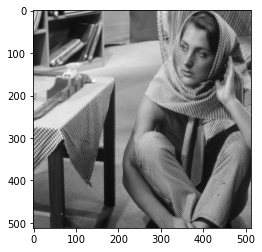

In [9]:
img = io.imread('0.bmp')

raw_img = (color.rgb2gray(img) * 255).astype(np.int)

plt.imshow(raw_img, cmap='gray')

QF: 25
PSNR: 29.29806376942523 dB


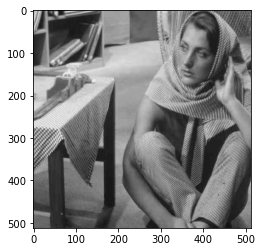

In [10]:
quality = 25

quant_table2 = np.int64(QF(quant_table, quality))

out_img = np.uint32(compress_img(raw_img, quality, quant_table2))

plt.imshow(out_img, cmap='gray')

print('QF: {}'.format(quality))
print('PSNR:', PSNR(raw_img, out_img), 'dB')

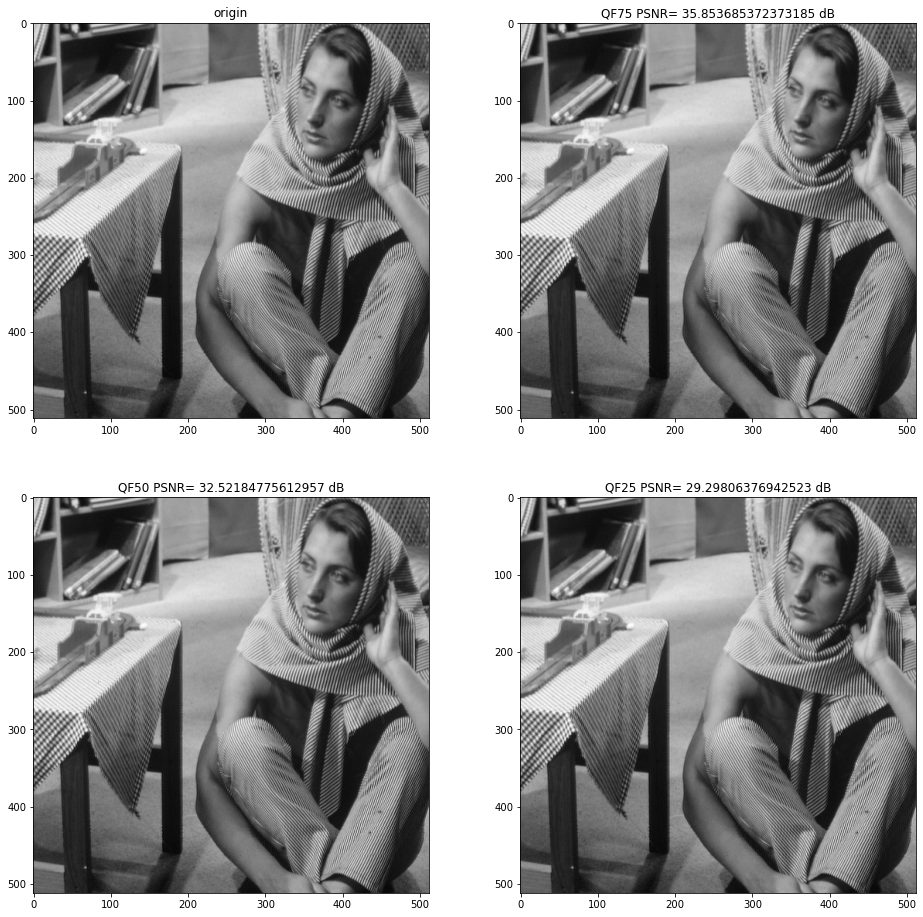

In [11]:
raw_img = io.imread('0.bmp')
raw_img = (color.rgb2gray(raw_img) * 255).astype(np.int)

plt.figure(num=4, figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title('origin')
plt.imshow(raw_img, cmap='gray')

for i, quality in enumerate([75, 50, 25]):
    quant_table2 = np.int64(QF(quant_table, quality))
    out_img = np.uint32(compress_img(raw_img, quality, quant_table2))

    plt.subplot(2, 2, i + 2)
    plt.title('QF{} PSNR= {} dB'.format(quality, PSNR(raw_img, out_img)))
    plt.imshow(raw_img, cmap='gray')
    
    io.imsave('qf{}.jpg'.format(quality), out_img.astype(np.uint8))